In [1]:
# INSTALL + IMPORTS
# RUN ONCE

# MOUNT GDRIVE
from google.colab import drive
drive.mount('/content/drive')

# YOLO
!pip install ultralytics
from ultralytics import YOLO
import cv2
import numpy as np
import torch
import os
import datetime
from pathlib import Path
import matplotlib.pyplot as plt

# OCR
!pip install -q reportlab pillow
import dill
from PIL import Image
from datetime import datetime
from transformers import VisionEncoderDecoderModel, TrOCRProcessor
import tempfile
import shutil

!pip install -q weasyprint
from datetime import datetime
from weasyprint import HTML
import tempfile
import os
from datetime import datetime





Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 30.2 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.3/316.3 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 69.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 847.1/847.1 kB 74.6 MB/s eta 0:00:00


First we install and import necessary dependencies,

then we run a sample image into the YOLO model, to detect text.


image 1/1 /content/drive/MyDrive/DATASET_FINAL/train/images/11-16_jpg.rf.ce28ae20e1cc1371ff28be097a95bcde.jpg: 1280x864 25 text-lines, 247.6ms
Speed: 31.3ms preprocess, 247.6ms inference, 6.1ms postprocess per image at shape (1, 3, 1280, 864)
Results saved to /content/runs/detect/predict3


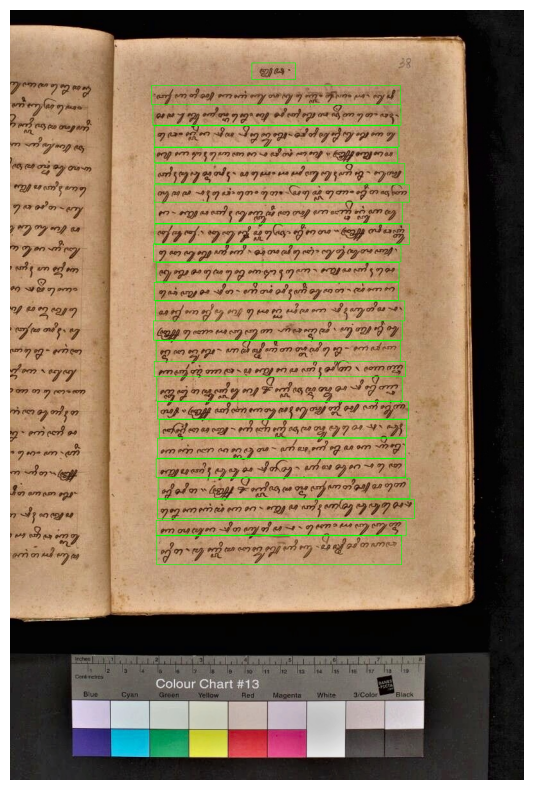

In [10]:
img_dir = "/content/drive/MyDrive/DATASET_FINAL/train/images/11-16_jpg.rf.ce28ae20e1cc1371ff28be097a95bcde.jpg"
model = YOLO("/content/drive/MyDrive/yolo_nusaaksara3/yolov8l_max_accuracy/weights/best.pt")

results = model.predict(img_dir, save=True, conf=0.5, iou=0.7)
res = results[0]
img = cv2.imread(img_dir)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

for box in res.boxes.xyxy:
    x1, y1, x2, y2 = map(int, box[:4])
    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 1)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis("off")
plt.show()



Next, we convert each bounded box into grayscale, ensuring sharp visibility for text and negate blur.

In [11]:

def enhance_for_ocr_adaptive_smart(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    mean_brightness = gray.mean()
    std_brightness = gray.std()

    upscaled = cv2.resize(gray, None, fx=1.8, fy=1.8, interpolation=cv2.INTER_CUBIC)

    h_param = 25 if std_brightness > 40 else 15
    denoised = cv2.fastNlMeansDenoising(upscaled, None, h=h_param, templateWindowSize=7, searchWindowSize=21)

    if mean_brightness < 120:
        C_param = 8
    elif mean_brightness > 180:
        C_param = 15
    else:
        C_param = 12

    adaptive = cv2.adaptiveThreshold(
        denoised, 255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV,
        blockSize=35,
        C=C_param
    )

    kernel = np.ones((2, 2), np.uint8)
    opened = cv2.morphologyEx(adaptive, cv2.MORPH_OPEN, kernel)
    closed = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, np.ones((1, 1), np.uint8))

    final = cv2.bitwise_not(closed)
    return final


Next, we combine all of our created functions before, and save each bounded box into google drive after reordering, and grayscaling them.

In [12]:
def save_cropped_boxes(results, image_path, output_dir_base, pad=10):
    import datetime

    timestamp_str = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    output_dir = os.path.join(output_dir_base, f"run_{timestamp_str}")
    os.makedirs(output_dir, exist_ok=True)

    img_original = cv2.imread(image_path)
    if img_original is None:
        print(f"❌ ERROR: Could not read {image_path}")
        return []

    image_name = Path(image_path).stem
    saved_crops = []

    if not (len(results) > 0 and hasattr(results[0], "boxes")):
        print("⚠️ No boxes detected.")
        return []

    detected_boxes = results[0].boxes
    boxes_array = detected_boxes.xyxy.cpu().numpy()
    conf_array = detected_boxes.conf.cpu().numpy()
    combined_boxes = np.hstack((boxes_array, conf_array[:, None]))

    def sort_boxes_two_columns(boxes):
        centers_x = [(b[0] + b[2]) / 2 for b in boxes]
        median_x = np.median(centers_x)
        left_col = [b for b in boxes if ((b[0] + b[2]) / 2) < median_x]
        right_col = [b for b in boxes if ((b[0] + b[2]) / 2) >= median_x]
        left_sorted = sorted(left_col, key=lambda b: b[1])
        right_sorted = sorted(right_col, key=lambda b: b[1])
        return left_sorted + right_sorted

    sorted_boxes = sorted(combined_boxes, key=lambda b: b[1])

    for i, box_data in enumerate(sorted_boxes):
        x1, y1, x2, y2, conf = box_data[:5]
        x1, y1, x2, y2 = map(int, [x1, y1, x2, y2])

        PAD_X = 15
        PAD_Y = 4

        h, w = img_original.shape[:2]
        x1 = max(0, x1 - PAD_X)
        y1 = max(0, y1 - PAD_Y)
        x2 = min(w, x2 + PAD_X)
        y2 = min(h, y2 + PAD_Y)


        if x2 <= x1 or y2 <= y1:
            print(f"⚠️ Skipping invalid box {i}.")
            continue

        cropped = img_original[y1:y2, x1:x2]
        enhanced_crop = enhance_for_ocr_adaptive_smart(cropped)

        crop_filename = f"{image_name}_line{i:02d}_conf{conf:.2f}.jpg"
        crop_path = os.path.join(output_dir, crop_filename)
        cv2.imwrite(crop_path, enhanced_crop)

        saved_crops.append({
            "filename": crop_filename,
            "bbox": (x1, y1, x2, y2),
            "confidence": conf
        })
        print(f"✅ Saved crop {i+1}: {crop_filename}")

    return saved_crops

crops = save_cropped_boxes(results, img_dir, "/content/drive/MyDrive/yolo_predictions/crops2/")


✅ Saved crop 1: 11-16_jpg.rf.ce28ae20e1cc1371ff28be097a95bcde_line00_conf0.71.jpg
✅ Saved crop 2: 11-16_jpg.rf.ce28ae20e1cc1371ff28be097a95bcde_line01_conf0.83.jpg
✅ Saved crop 3: 11-16_jpg.rf.ce28ae20e1cc1371ff28be097a95bcde_line02_conf0.87.jpg
✅ Saved crop 4: 11-16_jpg.rf.ce28ae20e1cc1371ff28be097a95bcde_line03_conf0.86.jpg
✅ Saved crop 5: 11-16_jpg.rf.ce28ae20e1cc1371ff28be097a95bcde_line04_conf0.83.jpg
✅ Saved crop 6: 11-16_jpg.rf.ce28ae20e1cc1371ff28be097a95bcde_line05_conf0.84.jpg
✅ Saved crop 7: 11-16_jpg.rf.ce28ae20e1cc1371ff28be097a95bcde_line06_conf0.83.jpg
✅ Saved crop 8: 11-16_jpg.rf.ce28ae20e1cc1371ff28be097a95bcde_line07_conf0.87.jpg
✅ Saved crop 9: 11-16_jpg.rf.ce28ae20e1cc1371ff28be097a95bcde_line08_conf0.85.jpg
✅ Saved crop 10: 11-16_jpg.rf.ce28ae20e1cc1371ff28be097a95bcde_line09_conf0.80.jpg
✅ Saved crop 11: 11-16_jpg.rf.ce28ae20e1cc1371ff28be097a95bcde_line10_conf0.78.jpg
✅ Saved crop 12: 11-16_jpg.rf.ce28ae20e1cc1371ff28be097a95bcde_line11_conf0.80.jpg
✅ Saved crop 

Next, we load our ocr model, processor and tokenizer from trained model

In [13]:
model_sir= "/content/drive/MyDrive/trocr_model_sunda_jawa_FINAL4"

def load_model(model_dir):
    print("Loading model...")

    tokenizer_path = os.path.join(model_dir, "custom_tokenizer.pkl")
    with open(tokenizer_path, 'rb') as f:
        tokenizer = dill.load(f)

    model = VisionEncoderDecoderModel.from_pretrained(model_dir)
    processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")

    if model.config.decoder_start_token_id != tokenizer.bos_token_id:
        model.config.decoder_start_token_id = tokenizer.bos_token_id

    model.eval()
    print("✅ Model loaded successfully!")

    return model, tokenizer, processor

model, tokenizer, processor = load_model("/content/drive/MyDrive/trocr_model_sunda_jawa_FINAL4")




Loading model...
✅ Model loaded successfully!


Next, we create our function for Transcription and a batch transcription for faster and efficient transcription of bounded boxes.

In [14]:

def ocr_image(image_path, model, tokenizer, processor):
    try:
        img = Image.open(image_path).convert("RGB")
        pixel_values = processor(images=img, return_tensors="pt").pixel_values

        with torch.no_grad():
            generated_ids = model.generate(
                pixel_values,
                max_length=96,
                num_beams=8,
                early_stopping=True,
                pad_token_id=tokenizer.pad_token_id,
                bos_token_id=tokenizer.bos_token_id,
                decoder_start_token_id=tokenizer.bos_token_id,
                eos_token_id=tokenizer.eos_token_id,
            )

        result = tokenizer.decode(generated_ids[0], skip_special_tokens=True)

        return result, img

    except Exception as e:
        print(f"❌ Error processing {image_path}: {e}")
        return None, None

def batch_ocr(image_folder, model, tokenizer, processor):
    results = []

    image_files = [f for f in os.listdir(image_folder)
                   if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]


    image_files.sort(key=lambda x: x.lower())

    print(f"\nProcessing {len(image_files)} images...")
    print("="*60)

    for i, img_file in enumerate(image_files, 1):
        img_path = os.path.join(image_folder, img_file)

        print(f"[{i}/{len(image_files)}] Processing: {img_file}")

        text, img = ocr_image(img_path, model, tokenizer, processor)

        if text is not None:
            results.append({
                'filename': img_file,
                'filepath': img_path,
                'text': text,
                'image': img,
                'success': True
            })


            plt.figure(figsize=(8, 4))
            plt.imshow(img)
            plt.axis("off")
            plt.title(f"{img_file}\n{text}", fontsize=10)
            plt.show()
            print(f"  Result: '{text}'")
        else:
            results.append({
                'filename': img_file,
                'filepath': img_path,
                'text': 'ERROR',
                'image': None,
                'success': False
            })
            print(f"  Result: ERROR")

    print("="*60)
    print(f"✅ Completed: {sum(r['success'] for r in results)}/{len(results)} successful\n")

    return results


Next, we create a function to export our transcripted text into a simple html page to convert into pdf.

In [15]:

def export_to_html_simple(results, output_path="ocr_results.html"):
    total = len(results)
    successful = sum(r['success'] for r in results)
    success_rate = (successful / total * 100) if total > 0 else 0

    html_content = f"""<!DOCTYPE html>
<html lang="jv">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>OCR Results - Aksara Jawa/Sunda</title>
    <link rel="preconnect" href="https://fonts.googleapis.com">
    <link rel="preconnect" href="https://fonts.gstatic.com" crossorigin>
    <link href="https://fonts.googleapis.com/css2?family=Noto+Sans+Javanese:wght@400;700&display=swap" rel="stylesheet">
    <style>
        * {{
            margin: 0;
            padding: 0;
            box-sizing: border-box;
        }}

        body {{
            font-family: 'Segoe UI', Arial, sans-serif;
            background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
            min-height: 100vh;
            padding: 40px 20px;
        }}

        .container {{
            max-width: 1000px;
            margin: 0 auto;
        }}

        .header {{
            background: white;
            padding: 40px;
            border-radius: 16px;
            box-shadow: 0 20px 60px rgba(0, 0, 0, 0.3);
            margin-bottom: 30px;
            text-align: center;
        }}

        .header h1 {{
            color: #2c3e50;
            font-size: 32px;
            margin-bottom: 10px;
        }}

        .header .date {{
            color: #7f8c8d;
            font-size: 14px;
            margin-bottom: 20px;
        }}

        .stats {{
            display: flex;
            justify-content: center;
            gap: 40px;
            margin-top: 20px;
        }}

        .stat {{
            text-align: center;
        }}

        .stat-number {{
            font-size: 36px;
            font-weight: bold;
            color: #667eea;
        }}

        .stat-label {{
            color: #95a5a6;
            font-size: 12px;
            text-transform: uppercase;
            letter-spacing: 1px;
        }}

        .result-card {{
            background: white;
            border-radius: 12px;
            padding: 30px;
            margin-bottom: 20px;
            box-shadow: 0 10px 30px rgba(0, 0, 0, 0.2);
            transition: transform 0.3s ease, box-shadow 0.3s ease;
        }}

        .result-card:hover {{
            transform: translateY(-5px);
            box-shadow: 0 15px 40px rgba(0, 0, 0, 0.3);
        }}

        .result-header {{
            display: flex;
            justify-content: space-between;
            align-items: center;
            margin-bottom: 20px;
            padding-bottom: 15px;
            border-bottom: 2px solid #ecf0f1;
        }}

        .result-number {{
            background: #667eea;
            color: white;
            width: 40px;
            height: 40px;
            border-radius: 50%;
            display: flex;
            align-items: center;
            justify-content: center;
            font-weight: bold;
            font-size: 18px;
        }}

        .filename {{
            flex: 1;
            margin: 0 20px;
            font-weight: 600;
            color: #2c3e50;
            font-size: 16px;
        }}

        .status {{
            padding: 6px 16px;
            border-radius: 20px;
            font-size: 14px;
            font-weight: 600;
        }}

        .status.success {{
            background: #d4edda;
            color: #155724;
        }}

        .status.failed {{
            background: #f8d7da;
            color: #721c24;
        }}

        .ocr-text {{
            font-family: 'Noto Sans Javanese', Arial, sans-serif;
            font-size: 24px;
            line-height: 2;
            color: #2c3e50;
            background: #f8f9fa;
            padding: 25px;
            border-radius: 8px;
            border-left: 5px solid #667eea;
            word-wrap: break-word;
            direction: ltr;
        }}

        .error-text {{
            color: #e74c3c;
            font-style: italic;
            padding: 20px;
            text-align: center;
        }}

        @media print {{
            body {{
                background: white;
                padding: 20px;
            }}

            .result-card {{
                page-break-inside: avoid;
                box-shadow: none;
                border: 1px solid #ddd;
            }}
        }}
    </style>
</head>
<body>
    <div class="container">
        <div class="header">
            <h1>📜 OCR Results</h1>
            <h2>Aksara Jawa/Sunda</h2>
            <div class="date">{datetime.now().strftime('%A, %B %d, %Y - %H:%M:%S')}</div>

            <div class="stats">
                <div class="stat">
                    <div class="stat-number">{total}</div>
                    <div class="stat-label">Total Images</div>
                </div>
                <div class="stat">
                    <div class="stat-number">{successful}</div>
                    <div class="stat-label">Successful</div>
                </div>
                <div class="stat">
                    <div class="stat-number">{success_rate:.1f}%</div>
                    <div class="stat-label">Success Rate</div>
                </div>
            </div>
        </div>
"""

    for i, result in enumerate(results, 1):
        status_class = "success" if result['success'] else "failed"
        status_text = "✓ Success" if result['success'] else "✗ Failed"

        html_content += f"""
        <div class="result-card">
            <div class="result-header">
                <div class="result-number">{i}</div>
                <div class="filename">{result['filename']}</div>
                <div class="status {status_class}">{status_text}</div>
            </div>
"""

        if result['success'] and result.get('text'):
            text = result['text'].replace('&', '&amp;').replace('<', '&lt;').replace('>', '&gt;')
            html_content += f'<div class="ocr-text">{text}</div>'
        else:
            html_content += '<div class="error-text">❌ Failed to process image</div>'

        html_content += """
        </div>
"""

    html_content += """
    </div>
</body>
</html>
"""

    with open(output_path, 'w', encoding='utf-8') as f:
        f.write(html_content)

    print(f"✅ HTML report generated: {output_path}")
    print(f"📂 Open this file in your browser to view results")
    return output_path

Next, we execute our created function before of ocr, batch ocr and create html to create a simple page from collected transcripted output of ocr to then export as PDF using weasyprint.

It will then automatically download the results into local computer


Processing 25 images...
[1/25] Processing: 11-16_jpg.rf.ce28ae20e1cc1371ff28be097a95bcde_line00_conf0.71.jpg


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 43396 (\N{JAVANESE LETTER A}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


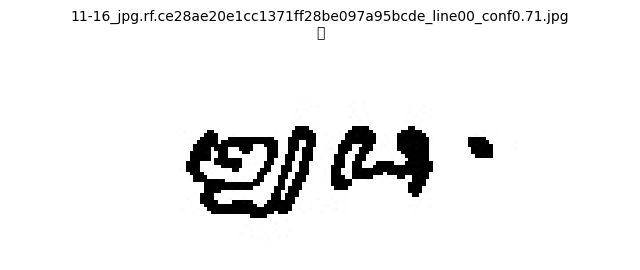

  Result: 'ꦄ'
[2/25] Processing: 11-16_jpg.rf.ce28ae20e1cc1371ff28be097a95bcde_line01_conf0.83.jpg


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 43424 (\N{JAVANESE LETTER TA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 43448 (\N{JAVANESE VOWEL SIGN SUKU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 43394 (\N{JAVANESE SIGN LAYAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 43442 (\N{JAVANESE LETTER HA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 43435 (\N{JAVANESE LETTER RA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/us

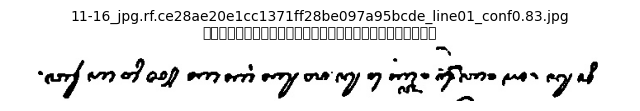

  Result: 'ꦠꦸꦂꦲꦫꦶꦉꦒꦏꦁꦏꦸꦭꦤꦸꦒ꧀ꦏꦺꦫꦼꦒꦢ꧈ꦩꦸꦢꦶ'
[3/25] Processing: 11-16_jpg.rf.ce28ae20e1cc1371ff28be097a95bcde_line02_conf0.87.jpg


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 43441 (\N{JAVANESE LETTER SA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 43429 (\N{JAVANESE LETTER PA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 43431 (\N{JAVANESE LETTER BA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 43444 (\N{JAVANESE VOWEL SIGN TARUNG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 43438 (\N{JAVANESE LETTER WA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/u

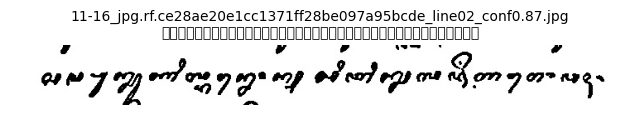

  Result: 'ꦱꦥꦸꦒ꧀ꦒꦸꦏꦶꦭ꧀ꦧꦤ꧀ꦤꦺꦴꦤ꧀ꦤꦸꦱꦶꦠꦶꦤ꧀ꦤꦭꦢꦼꦁꦒꦒꦺꦮꦃ꧈'
[4/25] Processing: 11-16_jpg.rf.ce28ae20e1cc1371ff28be097a95bcde_line03_conf0.86.jpg


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 43413 (\N{JAVANESE LETTER CA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


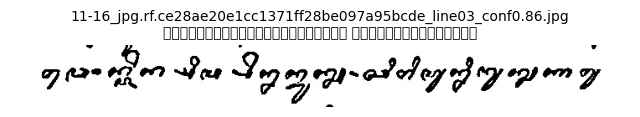

  Result: 'ꦮꦺꦤ꧀ꦢꦶꦤ꧀ꦥꦶꦥ꧀ꦥꦶꦤ꧀ꦤꦺꦤ꧀ꦒꦸ ꦕꦶꦒꦶꦥꦸꦤ꧀ꦤꦶꦒꦸꦒꦫꦸ'
[5/25] Processing: 11-16_jpg.rf.ce28ae20e1cc1371ff28be097a95bcde_line04_conf0.83.jpg


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 43412 (\N{JAVANESE LETTER NGA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 43454 (\N{JAVANESE CONSONANT SIGN PENGKAL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


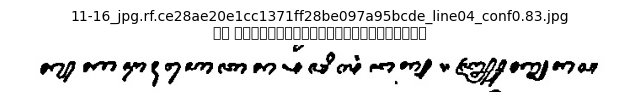

  Result: 'ꦏ꧀ ꦏꦤꦺꦃꦲꦺꦠꦤ꧀ꦥꦶꦭꦁꦏꦒꦸ꧈ꦔꦾꦏ꧀‌ꦤꦥ'
[6/25] Processing: 11-16_jpg.rf.ce28ae20e1cc1371ff28be097a95bcde_line05_conf0.84.jpg


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 43434 (\N{JAVANESE LETTER YA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 43439 (\N{JAVANESE LETTER SA MURDA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


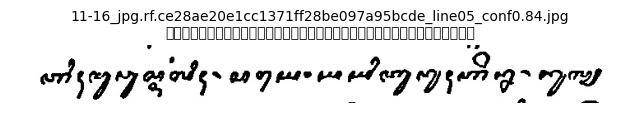

  Result: 'ꦠꦶꦃꦔꦸꦮꦸꦤ꧀ꦢꦁꦭꦶꦃ꧈ꦥꦪꦺꦴꦢꦢꦶꦧꦸꦤꦸꦃꦲꦼꦤ꧀ꦤ꧈ꦯꦸꦭ꧀'
[7/25] Processing: 11-16_jpg.rf.ce28ae20e1cc1371ff28be097a95bcde_line06_conf0.83.jpg


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 43415 (\N{JAVANESE LETTER JA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


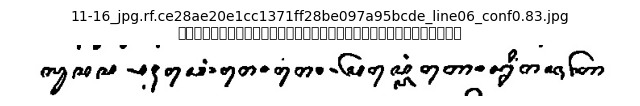

  Result: 'ꦭꦸꦥ꧀ꦥꦃꦮꦺꦴꦁꦫꦺꦴꦒꦺ꧈ꦥꦼꦥ꧀ꦧꦺꦁꦒꦺꦴꦤ꧀ꦤꦶꦫꦗꦏꦼ'
[8/25] Processing: 11-16_jpg.rf.ce28ae20e1cc1371ff28be097a95bcde_line07_conf0.87.jpg


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 43418 (\N{JAVANESE LETTER NYA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


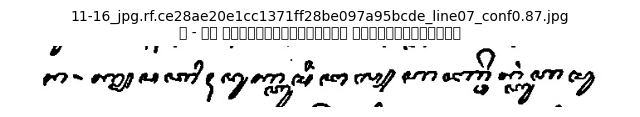

  Result: 'ꦤ - ꦏ꧀ ꦥꦠꦶꦃꦢꦸꦏ꧀ꦠꦸꦩꦶꦠꦭ꧀ ꦲꦚ꧀ꦗꦼꦤ꧀ꦠꦸꦁꦠꦩꦸ'
[9/25] Processing: 11-16_jpg.rf.ce28ae20e1cc1371ff28be097a95bcde_line08_conf0.85.jpg


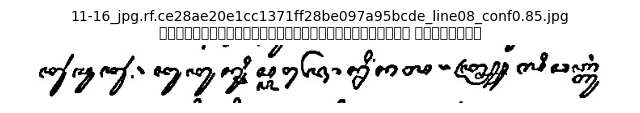

  Result: 'ꦠꦸꦂꦩꦸꦠꦸꦂ꧈ꦔꦸꦠꦸꦤ꧀ꦤꦶꦥ꧀ꦠꦪꦺꦴꦤ꧀ꦤꦶꦤꦭ꧀ ꦔꦾꦭꦶꦕꦒꦸꦁ'
[10/25] Processing: 11-16_jpg.rf.ce28ae20e1cc1371ff28be097a95bcde_line09_conf0.80.jpg


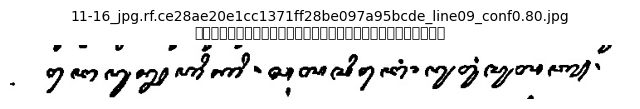

  Result: 'ꦔꦺꦤ꧀ꦤꦺꦲꦶꦏꦶ꧈ꦱꦭꦥꦶꦧꦺꦴꦁꦫꦸꦒꦸꦁꦥꦸꦭꦚ꧀꧈'
[11/25] Processing: 11-16_jpg.rf.ce28ae20e1cc1371ff28be097a95bcde_line10_conf0.78.jpg


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 43419 (\N{JAVANESE LETTER TTA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


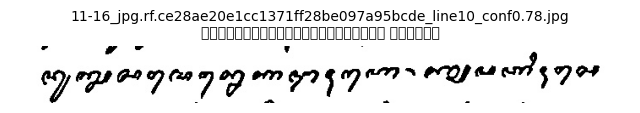

  Result: 'ꦢꦸꦭ꧀ꦤꦺꦱꦢꦺꦤ꧀ꦤꦺꦏꦛꦺꦃꦲꦺ꧈ꦏ꧀ ꦥꦲꦶꦃꦢꦺ'
[12/25] Processing: 11-16_jpg.rf.ce28ae20e1cc1371ff28be097a95bcde_line11_conf0.80.jpg


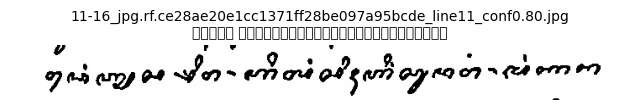

  Result: 'ꦢꦺꦁꦠ꧀ ꦱ꧀ꦱꦶꦫ꧈ꦏꦶꦭꦁꦱꦶꦃꦠꦶꦱꦸꦗꦮꦁ꧈ꦭꦁꦏꦤ'
[13/25] Processing: 11-16_jpg.rf.ce28ae20e1cc1371ff28be097a95bcde_line12_conf0.84.jpg


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 43421 (\N{JAVANESE LETTER DDA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


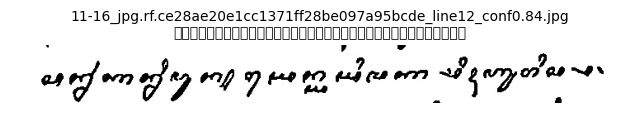

  Result: 'ꦥꦤ꧀ꦤꦂꦏꦤ꧀ꦤꦶꦥꦸꦤꦸꦫꦺꦤ꧀ꦝꦱꦶꦮꦏ꧀ꦥꦶꦃꦲꦸꦒꦶꦥ꧀ꦱ꧈'
[14/25] Processing: 11-16_jpg.rf.ce28ae20e1cc1371ff28be097a95bcde_line13_conf0.83.jpg


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 43467 (\N{JAVANESE PADA ADEG ADEG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


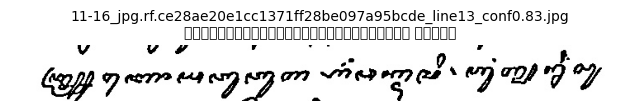

  Result: '꧋ꦠꦾꦫꦠꦺꦱꦠꦸꦠꦸꦒ꧀ꦲꦶꦮꦏ꧀ꦩꦮꦶ꧈ꦠꦸꦁꦒ꧀ ꦫꦸꦁꦱꦸ'
[15/25] Processing: 11-16_jpg.rf.ce28ae20e1cc1371ff28be097a95bcde_line14_conf0.84.jpg


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 43423 (\N{JAVANESE LETTER NA MURDA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


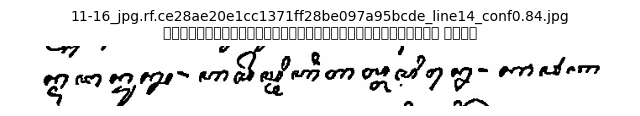

  Result: 'ꦒ꧀ꦩꦺꦔꦤ꧀ꦢꦸꦤ꧀ꦤꦺ꧈ꦲꦱꦼꦥ꧀ꦛꦶꦠꦶꦒꦭ꧀ꦩꦥꦶꦤ꧀ꦤꦺ ꦏꦗꦂꦟ'
[16/25] Processing: 11-16_jpg.rf.ce28ae20e1cc1371ff28be097a95bcde_line15_conf0.86.jpg


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 43453 (\N{JAVANESE CONSONANT SIGN KERET}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


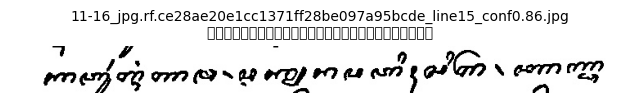

  Result: 'ꦏꦠꦸꦂꦒꦽꦁꦒꦮ꧈ꦥꦏ꧀‌ꦤꦥꦠꦶꦃꦱꦂꦒꦼ꧈ꦏꦟ꧀ꦧ'
[17/25] Processing: 11-16_jpg.rf.ce28ae20e1cc1371ff28be097a95bcde_line16_conf0.88.jpg


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 43432 (\N{JAVANESE LETTER BA MURDA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


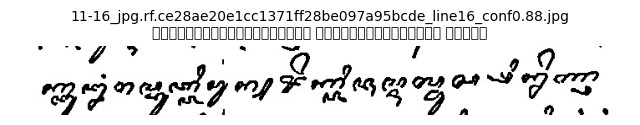

  Result: 'ꦏ꧀ꦕꦸꦯꦸꦫꦥ꧀ꦢꦸꦠ꧀ꦠꦶꦥꦸꦤ꧀ ꦨꦼꦟ꧀ꦠꦶꦢꦭ꧀ꦮꦸꦱ꧀ꦱꦶ ꦫꦸꦟ꧀ꦝ'
[18/25] Processing: 11-16_jpg.rf.ce28ae20e1cc1371ff28be097a95bcde_line17_conf0.88.jpg


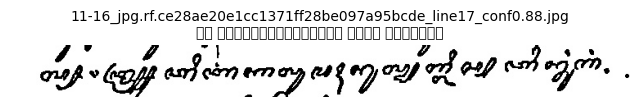

  Result: 'ꦭ꧀ ꧈ꦠꦾꦠꦶꦠꦏꦫꦸꦥꦃꦤꦸꦭ꧀ ꦒꦶꦱ꧀ ꦠꦶꦤꦸꦁꦒꦁ'
[19/25] Processing: 11-16_jpg.rf.ce28ae20e1cc1371ff28be097a95bcde_line18_conf0.87.jpg


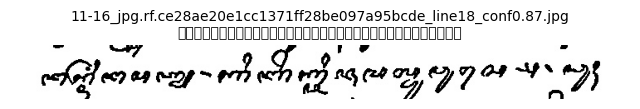

  Result: 'ꦩꦤ꧀ꦩꦶꦔꦥ꧀ꦮ꧈ꦏꦶꦧꦼꦟ꧀ꦭꦶꦗꦪꦭ꧀ꦭꦸꦮꦸꦱ꧀ꦱꦺ꧈ꦱꦸꦶ'
[20/25] Processing: 11-16_jpg.rf.ce28ae20e1cc1371ff28be097a95bcde_line19_conf0.88.jpg


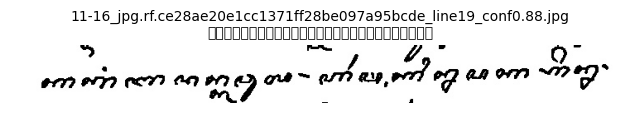

  Result: 'ꦏꦏꦁꦧꦤ꧀ꦏꦸꦭ꧈ꦲꦂꦗꦏꦶꦤ꧀ꦤꦥꦏ꧀ꦲꦶꦏ꧀ꦤ꧈'
[21/25] Processing: 11-16_jpg.rf.ce28ae20e1cc1371ff28be097a95bcde_line20_conf0.88.jpg


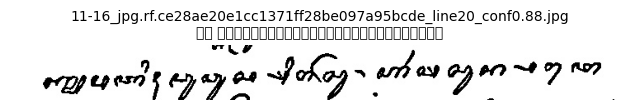

  Result: 'ꦏ꧀ ꦥꦠꦶꦃꦱꦸꦮꦸꦱ꧀ꦥꦶꦤꦼꦱꦸ꧈ꦲꦂꦮꦱꦸꦤ꧀ꦱꦠꦺ'
[22/25] Processing: 11-16_jpg.rf.ce28ae20e1cc1371ff28be097a95bcde_line21_conf0.88.jpg


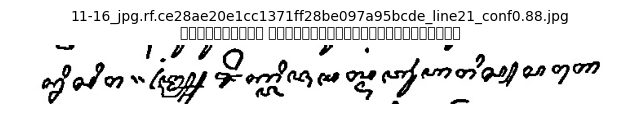

  Result: 'ꦤ꧀ꦤꦶꦱꦶꦫ꧈ꦠ꧀ ꦫꦼꦏ꧀ꦠꦶꦗꦥꦭ꧀ꦗꦠꦸꦂꦲꦒꦶꦱ꧀ꦤꦥꦒꦺ'
[23/25] Processing: 11-16_jpg.rf.ce28ae20e1cc1371ff28be097a95bcde_line22_conf0.86.jpg


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 43465 (\N{JAVANESE PADA LUNGSI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


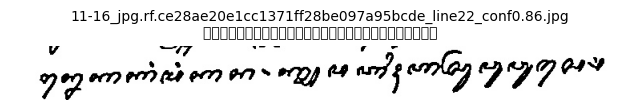

  Result: 'ꦤ꧀ꦤꦺꦏꦏꦁꦔꦁꦏꦤ꧈ꦏ꧀‌ꦢꦠꦶꦃꦲꦱꦸꦥꦸꦮꦸꦱꦺ꧉'
[24/25] Processing: 11-16_jpg.rf.ce28ae20e1cc1371ff28be097a95bcde_line23_conf0.76.jpg


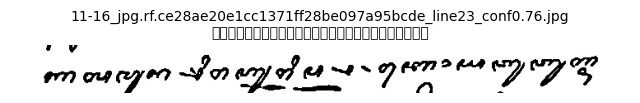

  Result: 'ꦏꦪꦤ꧀ꦱꦶꦫꦏꦸꦫꦶꦥ꧀ꦱ꧈ꦏꦺꦴꦥꦧꦸꦠꦸꦒ꧀ꦮ'
[25/25] Processing: 11-16_jpg.rf.ce28ae20e1cc1371ff28be097a95bcde_line24_conf0.89.jpg


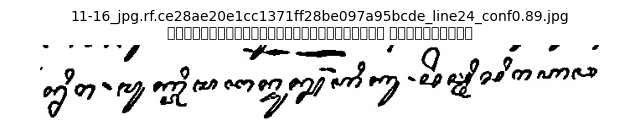

  Result: 'ꦤ꧀ꦤꦶꦫ꧈ꦭꦸꦏ꧀ꦝꦶꦩꦔꦤ꧀ꦢꦸꦤ꧀ꦤꦁꦠꦶꦒꦸ ꦥꦼꦩ꧀ꦮꦶꦱꦶꦭꦮ'
✅ Completed: 25/25 successful

Generating PDF document...


DEBUG:fontTools.ttLib.ttFont:Reading 'maxp' table from disk
DEBUG:fontTools.ttLib.ttFont:Decompiling 'maxp' table
DEBUG:fontTools.subset.timer:Took 0.002s to load 'maxp'
DEBUG:fontTools.subset.timer:Took 0.000s to prune 'maxp'
INFO:fontTools.subset:maxp pruned
DEBUG:fontTools.ttLib.ttFont:Reading 'cmap' table from disk
DEBUG:fontTools.ttLib.ttFont:Decompiling 'cmap' table
DEBUG:fontTools.ttLib.ttFont:Reading 'post' table from disk
DEBUG:fontTools.ttLib.ttFont:Decompiling 'post' table
DEBUG:fontTools.subset.timer:Took 0.005s to load 'cmap'
DEBUG:fontTools.subset.timer:Took 0.000s to prune 'cmap'
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:fpgm dropped
INFO:fontTools.subset:prep dropped
INFO:fontTools.subset:cvt  dropped
INFO:fontTools.subset:kern dropped
DEBUG:fontTools.subset.timer:Took 0.000s to load 'post'
DEBUG:fontTools.subset.timer:Took 0.000s to prune 'post'
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:GPOS dropped
INFO:fontTools.subset:GSUB dropped
DEBUG:f

✅ PDF generated: ocr_results.pdf
📄 File size: 21.0 KB


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [16]:
path_dir="/content/drive/MyDrive/yolo_predictions/crops2/run_20251224_223816"

def export_to_pdf_document(results, output_path="ocr_results.pdf"):

    total = len(results)
    successful = sum(r['success'] for r in results)
    success_rate = (successful / total * 100) if total > 0 else 0

    html_content = f"""<!DOCTYPE html>
<html lang="jv">
<head>
    <meta charset="UTF-8">
    <title>OCR Results - Aksara Jawa/Sunda</title>
    <link href="https://fonts.googleapis.com/css2?family=Noto+Sans+Javanese:wght@400;700&display=swap" rel="stylesheet">
    <style>
        @page {{
            size: A4;
            margin: 2.5cm 2cm;
            @bottom-center {{
                content: counter(page);
                font-size: 10pt;
                color: #666;
            }}
        }}

        body {{
            font-family: 'Times New Roman', Georgia, serif;
            color: #000;
            font-size: 12pt;
            line-height: 1.5;
        }}

        .title-page {{
            text-align: center;
            margin-top: 150px;
            page-break-after: always;
        }}

        .title-page h1 {{
            font-size: 24pt;
            font-weight: bold;
            margin-bottom: 30px;
        }}

        .title-page .subtitle {{
            font-size: 14pt;
            margin-bottom: 60px;
        }}

        .title-page .date {{
            font-size: 11pt;
            color: #333;
        }}

        h2 {{
            font-size: 14pt;
            font-weight: bold;
            margin-top: 30px;
            margin-bottom: 15px;
            border-bottom: 1px solid #000;
            padding-bottom: 5px;
        }}

        .summary {{
            margin-bottom: 40px;
        }}

        .summary p {{
            margin: 5px 0;
        }}

        .result-entry {{
           margin-bottom: 25px;
           page-break-inside: auto;
        }}

        .result-header {{
            font-weight: bold;
            margin-bottom: 8px;
            font-size: 11pt;
        }}

        .result-text {{
            font-family: 'Noto Sans Javanese', 'Times New Roman', serif;
            font-size: 14pt;
            line-height: 1.8;
            margin-left: 15px;
            text-align: justify;
            color: #000;
        }}

        .error {{
            font-style: italic;
            color: #666;
            margin-left: 20px;
        }}

        .separator {{
            margin: 20px 0;
            border-bottom: 1px solid #ccc;
        }}
    </style>
</head>
<body>
    <!-- Title Page -->
    <div class="title-page">
        <h1>OCR RESULTS</h1>
        <div class="subtitle">Aksara Jawa/Sunda Character Recognition</div>
        <div class="date">
            {datetime.now().strftime('%B %d, %Y')}<br>
            {datetime.now().strftime('%H:%M:%S')}
        </div>
    </div>

    <!-- Summary -->
    <div class="summary">
        <h2>Summary</h2>
        <p><strong>Total Images Processed:</strong> {total}</p>
        <p><strong>Successfully Recognized:</strong> {successful}</p>
        <p><strong>Failed:</strong> {total - successful}</p>
        <p><strong>Success Rate:</strong> {success_rate:.1f}%</p>
    </div>

    <!-- Results -->
    <h2>Recognition Results</h2>
"""

    for i, result in enumerate(results, 1):
        status = "✓" if result['success'] else "✗"

        html_content += f"""
    <div class="result-entry">
"""

        if result['success'] and result.get('text'):
            text = result['text'].replace('&', '&amp;').replace('<', '&lt;').replace('>', '&gt;')
            html_content += f'        <div class="result-text">{text}</div>\n'
        else:
            html_content += '        <div class="error">Recognition failed</div>\n'

    html_content += """
</body>
</html>
"""

    with tempfile.NamedTemporaryFile(mode='w', suffix='.html', delete=False, encoding='utf-8') as tmp:
        tmp.write(html_content)
        tmp_path = tmp.name

    try:
        print("Generating PDF document...")
        HTML(tmp_path).write_pdf(output_path)
        print(f"✅ PDF generated: {output_path}")
        print(f"📄 File size: {os.path.getsize(output_path) / 1024:.1f} KB")
        return output_path
    finally:
        if os.path.exists(tmp_path):
            os.remove(tmp_path)

results = batch_ocr(
    image_folder=path_dir,
    model=model,
    tokenizer=tokenizer,
    processor=processor,
)

export_to_pdf_document(results, "ocr_results.pdf")

from google.colab import files
files.download('ocr_results.pdf')